In [195]:
### 1. 必要なモジュールのインポートと初期設定
import requests
from bs4 import BeautifulSoup
from retry import retry
import time
import logging
import sqlite3
import csv
from datetime import datetime
import re

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='scraping.log'
)

# ヘッダー設定
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# SUUMOの東京23区の物件検索URL
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&mb=0&mt=9999999&et=9999999&cn=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=25&pc=50&page={}'


In [196]:
### 2. データベースの初期化と管理
def init_database():
    """データベースの初期化"""
    conn = sqlite3.connect('suumo_properties_new.db')
    cursor = conn.cursor()
    
    # 既存のテーブルを削除（必要な場合）
    cursor.execute('DROP TABLE IF EXISTS properties')
    
    # 新しいテーブルを作成
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        station1_name TEXT,
        station1_time INTEGER,
        station2_name TEXT,
        station2_time INTEGER,
        rent INTEGER,
        area FLOAT,
        rent_per_sqm FLOAT
    )
    ''')
    
    conn.commit()
    return conn, cursor

def insert_to_database(conn, cursor, data_samples):
    """データベースへの挿入"""
    scrape_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    insert_query = '''
    INSERT INTO properties (
        scrape_date, station1_name, station1_time, 
        station2_name,station2_time, rent, area, rent_per_sqm
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    '''
    
    insert_data = [
        (
            scrape_date,
            sample['station1_name'],
            sample['station1_time'],
            sample['station2_name'],
            sample['station2_time'],
            sample['rent'],
            sample['area'],
            sample['rent_per_sqm']
        )
        for sample in data_samples
    ]
    
    cursor.executemany(insert_query, insert_data)
    conn.commit()

In [197]:
### 3. データ抽出ロジック
def extract_station_info(station_text):
    """駅情報から駅名と徒歩時間を抽出"""
    if not station_text or station_text == '不明':
        return None, None
    
    try:
        # 駅名と徒歩時間を分離
        parts = station_text.split('歩')
        station_name = parts[0].strip()
        
        # 徒歩時間を抽出
        time_match = re.search(r'(\d+)分', parts[1])
        walking_time = int(time_match.group(1)) if time_match else None
        
        return station_name, walking_time
    except:
        return station_text, None

def extract_property_data(property_item):
    """物件データの抽出"""
    property_data = []
    
    try:
        # 最寄り駅情報
        station_info = property_item.find(class_='cassetteitem_detail-col2')
        stations = station_info.find_all(class_='cassetteitem_detail-text')
        
        # 駅1の情報
        station1_text = stations[0].text if stations else '不明'
        station1_name, station1_time = extract_station_info(station1_text)
        
        # 駅2の情報
        station2_text = stations[1].text if len(stations) > 1 else '不明'
        station2_name, station2_time = extract_station_info(station2_text)
        
        # 部屋情報の取得
        rooms = property_item.find(class_='cassetteitem_other')
        for room in rooms.find_all(class_='js-cassette_link'):
            try:
                # 家賃を抽出
                rent_text = room.find(class_='cassetteitem_other-emphasis').text
                rent = int(rent_text.replace('万円', '').strip()) * 10000
                
                # 面積を抽出
                area_text = room.find(class_='cassetteitem_menseki').text
                area = float(area_text.replace('m2', '').strip())
                
                # 面積あたりの家賃を計算
                rent_per_sqm = rent / area if area > 0 else None
                
                room_data = {
                    'station1_name': station1_name,
                    'station1_time': station1_time,
                    'station2_name': station2_name,
                    'station2_time': station2_time,
                    'rent': rent,
                    'area': area,
                    'rent_per_sqm': rent_per_sqm
                }
                
                property_data.append(room_data)
            
            except (ValueError, AttributeError) as e:
                logging.error(f"部屋データの解析エラー: {e}")
                continue
    
    except Exception as e:
        logging.error(f"物件データ抽出エラー: {e}")
    
    return property_data

In [198]:
### 4. スクレイピング関連の関数
@retry(tries=3, delay=10, backoff=2)
def load_page(url):
    """ページの読み込み"""
    try:
        html = requests.get(url, headers=headers, timeout=20)
        html.raise_for_status()
        return BeautifulSoup(html.content, 'html.parser')
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise

def get_total_pages(soup):
    """総ページ数の取得"""
    try:
        page_links = soup.find('div', class_='pagination-parts').find_all('a')
        return int(page_links[-2].text)
    except:
        return 300


In [199]:
### 5. メイン関数の実行
def main():
    conn, cursor = init_database()
    
    try:
        # 最初のページで総ページ数を取得
        first_page_soup = load_page(url.format(1))
        max_page = get_total_pages(first_page_soup)
        
        for page in range(1, max_page + 1):
            # ページ間隔を設定（サーバー負荷に配慮）
            time.sleep(1)
            
            try:
                soup = load_page(url.format(page))
            except Exception as e:
                logging.error(f"ページ {page} の取得に失敗しました: {e}")
                continue
            
            properties = soup.find_all(class_='cassetteitem')
            
            all_data = []
            for prop in properties:
                property_data = extract_property_data(prop)
                all_data.extend(property_data)
            
            # データベースに保存
            insert_to_database(conn, cursor, all_data)
            
            # 進捗表示
            print(f'ページ {page}/{max_page} 完了 ({round(page/max_page*100, 2)}%)')
            logging.info(f'ページ {page} 完了')

    except Exception as e:
        logging.error(f"スクレイピング中にエラー発生: {e}")
        print(f"エラー: {e}")
    
    finally:
        conn.close()
        logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

ページ 1/300 完了 (1.0%)
ページ 2/300 完了 (2.0%)
ページ 3/300 完了 (3.0%)
ページ 4/300 完了 (4.0%)
ページ 5/300 完了 (5.0%)
ページ 6/300 完了 (6.0%)
ページ 7/300 完了 (7.0%)
ページ 8/300 完了 (8.0%)
ページ 9/300 完了 (9.0%)
ページ 10/300 完了 (10.0%)
ページ 11/300 完了 (11.0%)
ページ 12/300 完了 (12.0%)
ページ 13/300 完了 (13.0%)
ページ 14/300 完了 (14.0%)
ページ 15/300 完了 (15.0%)
ページ 16/300 完了 (16.0%)
ページ 17/300 完了 (17.0%)
ページ 18/300 完了 (18.0%)
ページ 19/300 完了 (19.0%)
ページ 20/300 完了 (20.0%)
ページ 21/300 完了 (21.0%)
ページ 22/300 完了 (22.0%)
ページ 23/300 完了 (23.0%)
ページ 24/300 完了 (24.0%)
ページ 25/300 完了 (25.0%)
ページ 26/300 完了 (26.0%)
ページ 27/300 完了 (27.0%)
ページ 28/300 完了 (28.0%)
ページ 29/300 完了 (29.0%)
ページ 30/300 完了 (30.0%)
ページ 31/300 完了 (31.0%)
ページ 32/300 完了 (32.0%)
ページ 33/300 完了 (33.0%)
ページ 34/300 完了 (34.0%)
ページ 35/300 完了 (35.0%)
ページ 36/300 完了 (36.0%)
ページ 37/300 完了 (37.0%)
ページ 38/300 完了 (38.0%)
ページ 39/300 完了 (39.0%)
ページ 40/300 完了 (40.0%)
ページ 41/300 完了 (41.0%)
ページ 42/300 完了 (42.0%)
ページ 43/300 完了 (43.0%)
ページ 44/300 完了 (44.0%)
ページ 45/300 完了 (45.0%)
ページ 46/300 完了 (46.0%)
ページ 47

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

/Users/namboshunsuke/DSprog2/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39365 (\N{CJK UNIFIED IDEOGRAPH-99C5}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/namboshunsuke/DSprog2/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27497 (\N{CJK UNIFIED IDEOGRAPH-6B69}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/namboshunsuke/DSprog2/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38306 (\N{CJK UNIFIED IDEOGRAPH-95A2}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/namboshunsuke/DSprog2/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24112 (\N{CJK UNIFIED IDEOGRAPH-5E30}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


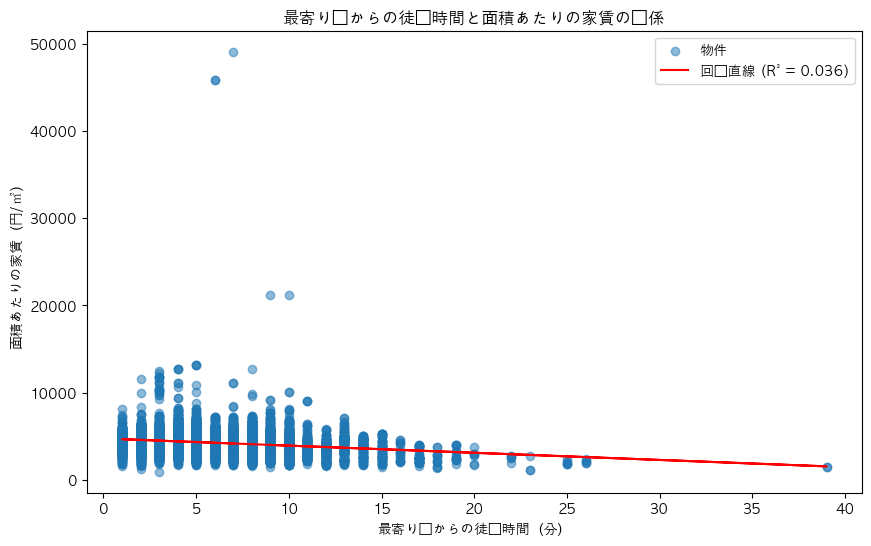


=== 統計分析結果 ===
相関係数: -0.190
決定係数 (R²): 0.036
p値: 0.0000

=== 徒歩時間帯ごとの平均家賃 ===
                  mean  count
time_category                
0-5分           4405.65   3846
6-10分          4168.57   3943
11-15分         3624.98    767
16-20分         2761.19    103
20分以上          2033.51     21


/var/folders/1q/hlhk155542xcsh2mg6dykksr0000gn/T/ipykernel_40870/1281401558.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_time = df.groupby('time_category')['rent_per_sqm'].agg(['mean', 'count']).round(2)


In [200]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import numpy as np
from scipy import stats

# データベースに接続
conn = sqlite3.connect('suumo_properties_new.db')

# データの取得
df = pd.read_sql_query("""
    SELECT station1_time, station2_time, rent_per_sqm
    FROM properties 
    WHERE rent_per_sqm IS NOT NULL
""", conn)

# より近い駅の徒歩時間を採用
df['min_walking_time'] = df[['station1_time', 'station2_time']].min(axis=1)

# 異常値の除外（例：徒歩時間が0分未満や60分以上のデータを除外）
df = df[df['min_walking_time'].between(1, 60)]

# 1. 散布図と回帰直線
plt.figure(figsize=(10, 6))
plt.scatter(df['min_walking_time'], df['rent_per_sqm'], alpha=0.5, label='物件')

# 回帰直線の追加
slope, intercept, r_value, p_value, std_err = stats.linregress(df['min_walking_time'], df['rent_per_sqm'])
line = slope * df['min_walking_time'] + intercept
plt.plot(df['min_walking_time'], line, color='red', label=f'回帰直線 (R² = {r_value**2:.3f})')

plt.title('最寄り駅からの徒歩時間と面積あたりの家賃の関係')
plt.xlabel('最寄り駅からの徒歩時間（分）')
plt.ylabel('面積あたりの家賃（円/㎡）')
plt.legend()
plt.show()

# 2. 相関係数と統計的検定の結果
print("\n=== 統計分析結果 ===")
print(f"相関係数: {r_value:.3f}")
print(f"決定係数 (R²): {r_value**2:.3f}")
print(f"p値: {p_value:.4f}")

# 徒歩時間帯ごとの平均家賃も確認
df['time_category'] = pd.cut(df['min_walking_time'], 
                           bins=[0, 5, 10, 15, 20, np.inf], 
                           labels=['0-5分', '6-10分', '11-15分', '16-20分', '20分以上'])

avg_by_time = df.groupby('time_category')['rent_per_sqm'].agg(['mean', 'count']).round(2)
print("\n=== 徒歩時間帯ごとの平均家賃 ===")
print(avg_by_time)

# データベース接続のクローズ
conn.close()